# Mario: Basic Tasks

 **Goal:** Mario pick-up ladder, go to princess(goal) and avoid Bowser(obstacle) in 6x6 grid


Tasks:
1. Environment definition
2. State and Reward function
3. Q-learning update rule and policy (epsilon greedy and softmax)
4. Run and measure performance for multiple episodes, parameters

* observation_space = state space as the grid is a fully observable environment

In [ ]:
# Uncomment to download latest gym version
#!pip install gym==0.26.2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import gym
from gym import Env, logger, spaces, utils
import random
from enum import Enum
import pandas as pd

In [ ]:
print(gym.__version__)

0.25.2


In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Environment

In [ ]:
# The Warehouse is divided into a grid. Use these 'tiles' to represent the objects on the grid.
class GridTile(Enum):
    _Floor = 0
    Mario = 1
    Ladder = 2
    Weapon = 3
    Dragon = 4
    Princess = 5
    Dragon2 = 6

    # Return the first letter of tile nme
    def __str__(self):
        return self.name[:1]

In [ ]:
class gridEnv(gym.Env):
    def __init__(self, gridsize=(6, 6),
                 princess_position=(5,5),
                 dragon_position=(5,3),
                 dragon2_position=(4,3),
                 weapon_position=(4,5),
                 ladder_position=(3,2)):

        super(gridEnv, self).__init__()

        # Grid size 6x6
        self.gridsize = gridsize

        # Position of goal: Princess Peach
        self.princess_position = princess_position

        # Position of obstacle: dragon
        self.dragon_position = dragon_position

        # Position of obstacle: dragon 2
        self.dragon2_position = dragon2_position

        # Position of weapon
        self.weapon_position = weapon_position

        # Position of tool: Ladder
        self.ladder_position = ladder_position

        # Define action space: up, down, left, right
        self.action_space = spaces.Discrete(4)

        # Define observation space (state space): 0...5 rows/columns
        # Each position of the agent in the grid is a state
        self.observation_space = spaces.Box(low=0, high=max(self.gridsize), shape=(2,))

        # Define state where agent starts
        self.state = np.array([0, 0])

        # Initialise 6x6 grid where positions will be stored
        self.grid = np.zeros(self.gridsize)

        # Define ladder check
        self.ladder_pickup = False

        # Define weapon check
        self.weapon_pickup = False

        # Define if terminal state reached = learning episode ended
        self.done = False
        self.seed()

    def seed(self, seed=None):
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        if seed is not None:
            self.seed(seed)

        # Reset the Mario's position and the grid
        self.state = np.array([0, 0])
        self.done = False

        # Reset the grid (zeros) and place the goal position
        self.grid = np.zeros(self.gridsize)
        # Store positions
        self.grid[self.princess_position[0], self.princess_position[1]] = 2
        self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
        self.grid[self.ladder_position[0], self.ladder_position[1]] = 4
        self.grid[self.weapon_position[0], self.weapon_position[1]] = 5
        self.grid[self.dragon2_position[0], self.dragon2_position[1]] = 6

        self.ladder_pickup = False
        self.weapon_pickup = False

        return self.state


    def step(self, action):
        # Vi
        # Track old state
        old_state = self.state.copy()

        # Sultana
        # Move the agent based on the action: up, down, left, right
        if action == 0:  # Move up
            self.state[0] = max(0, self.state[0] - 1)
        elif action == 1:  # Move down
            self.state[0] = min(self.gridsize[0] - 1, self.state[0] + 1)
        elif action == 2:  # Move left
            self.state[1] = max(0, self.state[1] - 1)
        elif action == 3:  # Move right
            self.state[1] = min(self.gridsize[1] - 1, self.state[1] + 1)

        # Compute reward and check if episode ends
        reward, done = self.compute_reward(old_state)

        return self.state, reward, done


    def compute_reward(self, old_state):
        # Default penalty for each step taken
        reward = -1;
        self.done = False

        # Check if the agent reached the goal
        if np.array_equal(self.state, self.princess_position):
          if self.ladder_pickup == True:
            reward = 30
            self.done = True
          else:
            reward = 0
            self.done = True

        # Reward for picking up ladder
        elif np.array_equal(self.state, self.ladder_position):
          if self.ladder_pickup == False:
            reward = 10
            self.ladder_pickup = True

        # Reward for picking up weapon
        elif np.array_equal(self.state, self.weapon_position):
          if self.weapon_pickup == False:
            reward = 5
            self.weapon_pickup = True

        # Penalty for facing dragon 1 (with/without weapon)
        elif np.array_equal(self.state, self.dragon_position):
          if self.weapon_pickup == True:
            reward = -5
          else:
            reward = -30

        # Penalty for facing dragon 2 (with/without weapon)
        elif np.array_equal(self.state, self.dragon2_position):
          if self.weapon_pickup == True:
            reward = -5
          else:
            reward = -30

        # Vi
        # Penalty if the move was invalid (hit the wall)
        elif np.array_equal(self.state, old_state):
            reward = -10

        return reward, self.done


    # def render(self, mode='human'):
    #     # Clear the grid and update it with the agent's current position
    #     self.grid = np.zeros(self.gridsize)
    #     # Mario
    #     self.grid[self.state[0], self.state[1]] = 1
    #     # Princess Peach
    #     self.grid[self.princess_position[0], self.princess_position[1]] = 2

    #     # Dragon 1,2
    #     self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
    #     self.grid[self.ladder_position[0], self.ladder_position[1]] = 4

    #     # Plot the grid
    #     plt.imshow(self.grid, cmap='Blues', interpolation='nearest')
    #     #plt.xticks([])
    #     #plt.yticks([])
    #     plt.show()


    def render_2(self, mode='human'):
        # Print current state on console
        for r in range(self.gridsize[0]):
            for c in range(self.gridsize[1]):
                if ([r, c] == [self.state[0], self.state[1]]):
                    print(GridTile.Mario, end=' ')
                elif ([r,c] == [self.ladder_position[0],self.ladder_position[1]]):
                    print(GridTile.Ladder, end=' ')
                elif ([r,c] == [self.weapon_position[0],self.weapon_position[1]]):
                    print(GridTile.Weapon, end=' ')
                elif ([r,c] == [self.dragon_position[0], self.dragon_position[1]]):
                    print(GridTile.Dragon, end=' ')
                elif ([r,c] == [self.dragon2_position[0], self.dragon2_position[1]]):
                    print(GridTile.Dragon2, end=' ')
                elif ([r,c] == [self.princess_position[0], self.princess_position[1]]):
                    print(GridTile.Princess, end=' ')
                else:
                    print(GridTile._Floor, end=' ')

            print()
        print()


## 1. Experiment with ϵ-greedy

### Q-learning and ϵ-greedy policy

In [ ]:
def greedy_policy(q_table, state):
  action = np.argmax(q_table[state])
  return action


def epsilon_greedy_policy(q_table, state, epsilon, grid_width):
    flat_state = int(state[0]) * grid_width + int(state[1])  # Ensure integer index
    random_int = random.uniform(0, 1)
    if random_int < epsilon:
        #action = env.action_space.sample()
        action = np.random.choice(env.action_space.n)
    else:
        action = np.argmax(q_table[flat_state])
    return action


In [ ]:
def state_to_index(state, width):
    return state[0] * width + state[1]

# Q-learning function
def q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps):

    # Initialize Q-table with shape (36, 4) = (state, action)
    q_table = np.zeros((env.gridsize[0] * env.gridsize[1], env.action_space.n))

    total_reward = 0
    # Vi
    # Create a df to store episode and number of steps
    df_epsisode = pd.DataFrame(columns=['Episode','Num_steps', 'Reward'])

    for episode in range(episodes):
        #epsilon = min_epsilon + (epsilon- min_epsilon)*np.exp(-epsilon_decay*episodes)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)


        state = env.reset()

        # Convert state to index
        state_index = state_to_index(state, env.gridsize[1])

        #print(state)
        done = False

        # Vi
        num_step = 0
        reward_per_episode = 0
        print("--- Episode",episode,"---")
        # Sultana
        while not done and num_step <max_steps:

            # Choose action based on epsilon-greedy strategy
            action = epsilon_greedy_policy(q_table, state, epsilon, env.gridsize[1])

            # Take the action and observe the result
            next_state, reward, done = env.step(action)

            # Convert next state to index
            next_state_index = state_to_index(next_state, env.gridsize[1])

            # Update Q-table based on the Q-learning formula
            q_table[state_index, action] += alpha * (reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action])

            # Move to the next state
            state = next_state
            # Update the state index
            state_index = next_state_index
            #env.render_2()

            # Add up reward
            total_reward +=reward

            # Track number of steps
            num_step = num_step+1
            # Track reward per episode

            reward_per_episode += reward


        #epsilon = max(min_epsilon, epsilon * epsilon_decay)
        new_track = {'Episode':episode, 'Num_steps':num_step, 'Reward':reward_per_episode}
        df_epsisode.loc[len(df_epsisode)] = new_track
        print("--reward:", reward)
        print ('***epsilon:', epsilon)

        # Decay epsilon to reduce exploration over time



    return q_table, total_reward, df_epsisode

### Run Q-learning

#### Test Environment

In [ ]:
# Hyperparameters of Q-learning
alpha=0.5
gamma=0.9
epsilon = 1.0
epsilon_decay=0.999
min_epsilon = 0.05
episodes=1500
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_steps_1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.999
--- Episode 1 ---
--reward: 0
***epsilon: 0.998001
--- Episode 2 ---
--reward: 30
***epsilon: 0.997002999
--- Episode 3 ---
--reward: 30
***epsilon: 0.996005996001
--- Episode 4 ---
--reward: 30
***epsilon: 0.995009990004999
--- Episode 5 ---
--reward: 30
***epsilon: 0.994014980014994
--- Episode 6 ---
--reward: 30
***epsilon: 0.993020965034979
--- Episode 7 ---
--reward: 30
***epsilon: 0.9920279440699441
--- Episode 8 ---
--reward: -1
***epsilon: 0.9910359161258742
--- Episode 9 ---
--reward: 30
***epsilon: 0.9900448802097482
--- Episode 10 ---
--reward: 30
***epsilon: 0.9890548353295385
--- Episode 11 ---
--reward: 30
***epsilon: 0.988065780494209
--- Episode 12 ---
--reward: 30
***epsilon: 0.9870777147137147
--- Episode 13 ---
--reward: 30
***epsilon: 0.986090636999001
--- Episode 14 ---
--reward: 30
***epsilon: 0.9851045463620021
--- Episode 15 ---
--reward: 30
***epsilon: 0.98411944181564
--- Episode 16 ---
--reward: 30
***epsilon: 

In [ ]:
success=0
for i in range (len(df_episode_steps_1['Episode'].values)):
  if df_episode_steps_1['Reward'].values[i] > 29:
    success +=1

print('Successful episodes:',success)

Successful episodes: 246


In [ ]:
# Q-values dataframe for 36 states (6x6 grid position) and 4 actions (up, down, left, right)
Q_values=pd.DataFrame(q_table, columns=['up', 'down', 'left', 'right'])
Q_values

up       down       left      right
0    2.964282  13.262559   1.768714  12.714615
1    2.523340  14.967036  11.122616  14.669749
2   -2.904245  19.718297   5.101972   5.156757
3   -3.863199   3.600117  12.648407   2.718315
4   -3.562078   3.872114   2.447606   3.195780
5   -3.406792   7.131062   3.354771  -3.284376
6   11.095694  16.418121   3.918181  15.208557
7   13.335291  16.771820  12.921053  19.935061
8   15.036185  21.694558  16.124893  16.514211
9    3.945414  12.738956  20.019125   6.155824
10   2.917726   4.143638  13.036554   4.974671
11   3.500913   4.408706   9.555558  -3.057683
12  13.069408   8.872399   5.544571  18.899565
13  15.020746  14.909424  16.017429  18.792499
14  17.465035  23.739942  18.104475  19.174913
15  14.415256  15.055233  24.135628  16.686993
16  10.152784  23.491921  12.349452  11.188738
17   3.677909  22.462207   5.015603  10.500450
18  13.898291   2.591100  -3.032783   3.499528
19  16.110423   6.655219   9.554100  11.064172
20  19.718306  14.156337  14.009087  20.002738
21  19.468753  -5.030472  17.173446  23.450444
22  19.906887  26.196873  19.791182  26.296481
23  19.373086  28.615241  22.007092  14.436078
24   2.820313   2.504536  -3.887212   2.978170
25   9.406799   3.137041   2.526584  13.939812
26  17.331815   2.390923   7.035922  -8.152422
27  18.737359  -5.979781  10.405505  27.713104
28  23.836277  23.948474  13.738018  30.453125
29  26.061575  30.000000  27.695929  25.762624
30   3.093574  -4.014153  -6.268761   3.177428
31   5.450731  -5.014770   4.546217   3.086452
32   6.380207  -2.891188   1.764572 -10.576343
33  -6.743527  -8.285175   4.077827  22.060556
34  27.790202  11.097816 -12.105872  14.999971
35   0.000000   0.000000   0.000000   0.000000

In [ ]:
df_episode_steps_1['Reward'][50:60]

50   -137
51   -506
52    -46
53    -61
54   -151
55   -268
56    -39
57     -4
58     -3
59   -866
Name: Reward, dtype: int64

In [ ]:
# Convert Rewards/episode to series
rewards_series=pd.Series(df_episode_steps_1['Reward'].values, name="Reward")

steps_series=pd.Series(df_episode_steps_1['Num_steps'].values, name="Step")

rewards_series[0:6]

0   -189
1   -544
2   -434
3   -257
4   -462
5   -842
Name: Reward, dtype: int64

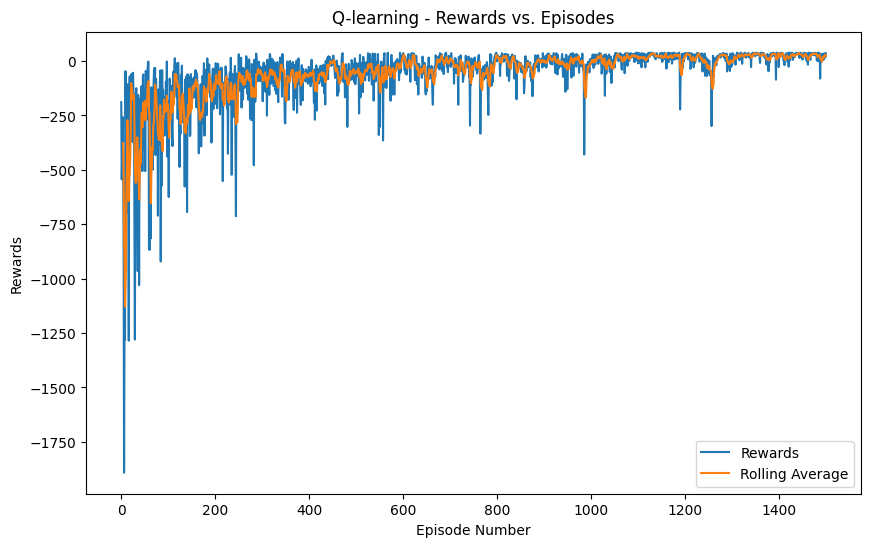

In [ ]:
#### Plot of Rewards and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = rewards_series.plot(ax=axes, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Rewards")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning - Rewards vs. Episodes")

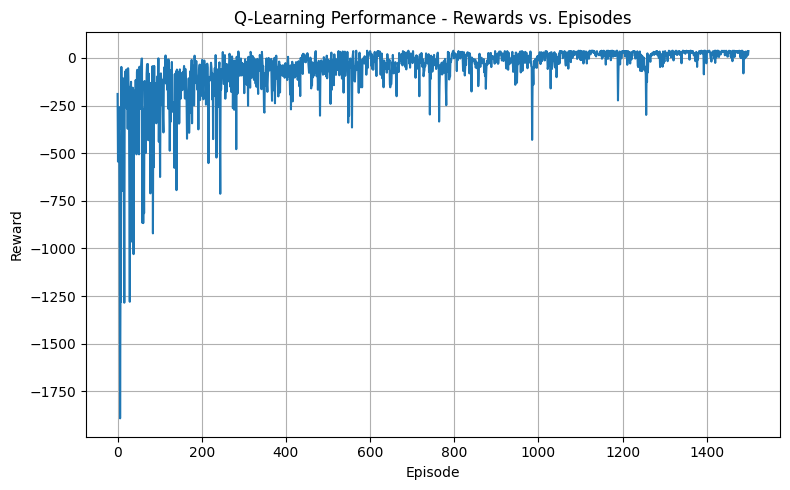

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps_1['Episode'], rewards_series)
plt.title('Q-Learning Performance - Rewards vs. Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.tight_layout()
plt.show()

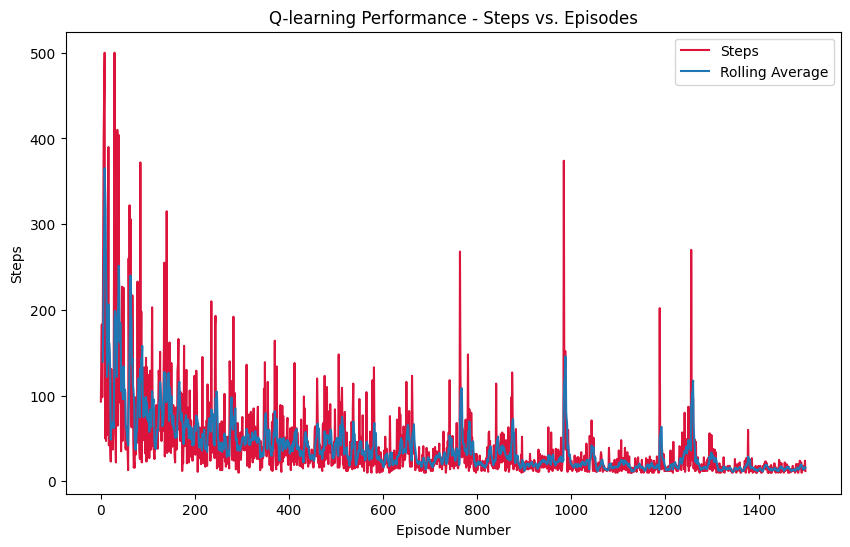

In [ ]:
#### Plot of Steps and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = steps_series.plot(ax=axes, label="Steps", color='crimson')
_ = (steps_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Steps")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Steps vs. Episodes")

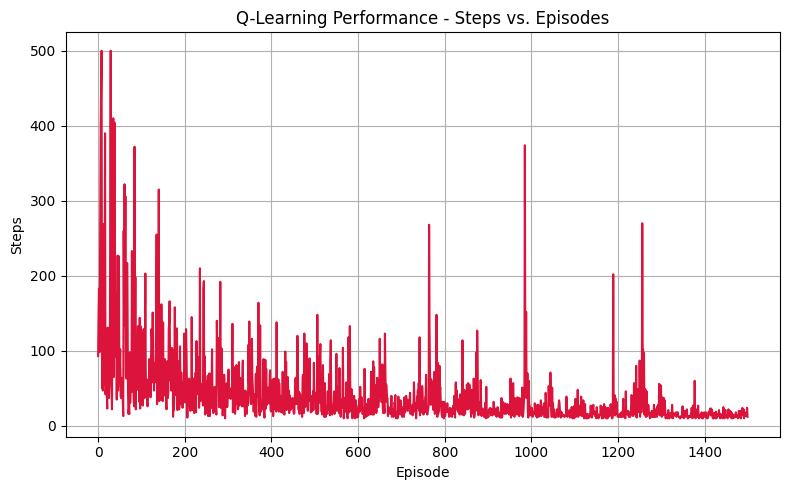

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps_1['Episode'], steps_series, color='crimson')
plt.title('Q-Learning Performance - Steps vs. Episodes')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Random Search: Best Parameters - Tuning

In [ ]:
import random
min_epsilon=0.05
max_steps=300

def random_search_q_learning(env, param_grid, num_samples=80):
    # Store the best parameters and performance
    best_params = None
    best_performance = float('-inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(num_samples):
        # Randomly sample values for each hyperparameter
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        epsilon_decay = random.choice(param_grid['epsilon_decay'])
        episodes = random.choice(param_grid['episodes'])

        # Initialize total reward tracker
        total_reward = 0

        # Call Q-learning function with the current set of hyperparameters
        #print(f"Running random search with: alpha={alpha}, gamma={gamma}, epsilon={epsilon}, epsilon_decay={epsilon_decay}, episodes={episodes}")
        q_table, total_reward, df_episode = q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon,max_steps, episodes)

        average_rewards = np.mean(df_episode['Reward'].values[-500:])

        # Record the best performance
        if average_rewards > best_performance:
            best_performance = average_rewards
            best_params = {'alpha': alpha, 'gamma': gamma, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay, 'episodes': episodes}

    return best_params, best_performance

# Define the hyperparameter grid (ranges for each hyperparameter)
param_grid = {
    'alpha': [0.1, 0.4, 0.7, 0.9],  # Learning rate
    'gamma': [0.4, 0.8, 0.9, 0.99],  # Discount factor
    'epsilon': [0.1,  0.5, 0.9, 1.0],  # Initial epsilon
    'epsilon_decay': [0.9, 0.99, 0.999, 0.9999],  # Decay factor for epsilon
    'episodes': [500, 1000, 1500],  # Number of episodes to run
}


# Perform random search
best_params, best_performance = random_search_q_learning(env, param_grid, num_samples=80)

# Output the results
print(f"Best parameters: {best_params}")
print(f"Best performance: {best_performance}")

Streaming output truncated to the last 5000 lines.
--- Episode 134 ---
--reward: 30
***epsilon: 0.8736568985103146
--- Episode 135 ---
--reward: 30
***epsilon: 0.8727832416118043
--- Episode 136 ---
--reward: 30
***epsilon: 0.8719104583701925
--- Episode 137 ---
--reward: 30
***epsilon: 0.8710385479118223
--- Episode 138 ---
--reward: 30
***epsilon: 0.8701675093639105
--- Episode 139 ---
--reward: 30
***epsilon: 0.8692973418545467
--- Episode 140 ---
--reward: 30
***epsilon: 0.8684280445126921
--- Episode 141 ---
--reward: 0
***epsilon: 0.8675596164681794
--- Episode 142 ---
--reward: 0
***epsilon: 0.8666920568517111
--- Episode 143 ---
--reward: 30
***epsilon: 0.8658253647948594
--- Episode 144 ---
--reward: 30
***epsilon: 0.8649595394300645
--- Episode 145 ---
--reward: 30
***epsilon: 0.8640945798906344
--- Episode 146 ---
--reward: 0
***epsilon: 0.8632304853107438
--- Episode 147 ---
--reward: 30
***epsilon: 0.862367254825433
--- Episode 148 ---
--reward: 30
***epsilon: 0.8615048875

In [ ]:
# Hyperparameters of Q-learning
alpha=0.2
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 0
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 0
***e

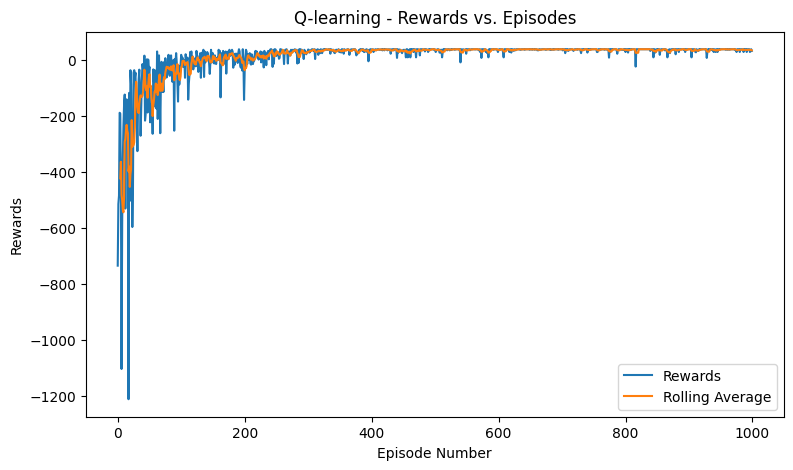

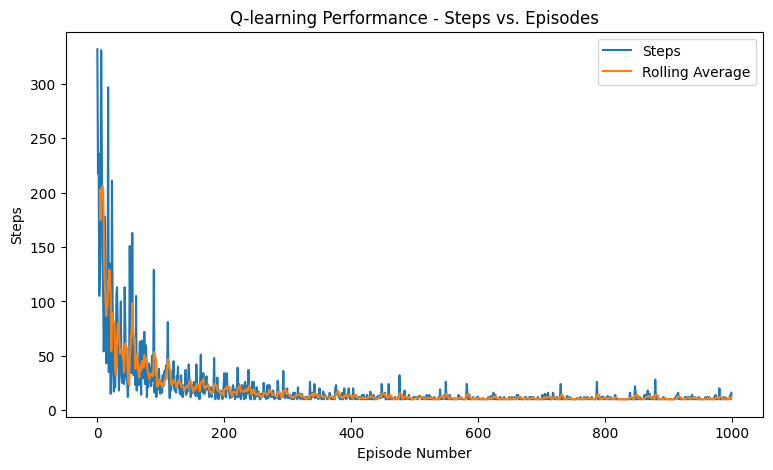

In [ ]:
# Convert Rewards/episode to series
rewards_series=pd.Series(df_episode['Reward'].values, name="Reward")
steps_series=pd.Series(df_episode['Num_steps'].values, name="Step")

######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series.plot(ax=ax, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=ax))
_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series.plot(ax=ax, label="Steps")
_ = (steps_series.rolling(window=5) .mean().rename("Rolling Average").plot(ax=ax))

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different Alpha values

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 0
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 0
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 0
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 0
***eps

In [ ]:
# Hyperparameters of Q-learning
alpha=0.4
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 0
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 0
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***e

In [ ]:
# Hyperparameters of Q-learning
alpha=0.7
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 0
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 0
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 0
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 0
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 0
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***epsi

In [ ]:
# Hyperparameters of Q-learning
alpha=0.9
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 0
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 0
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 0
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 0
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 0
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 0
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***epsil

In [ ]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

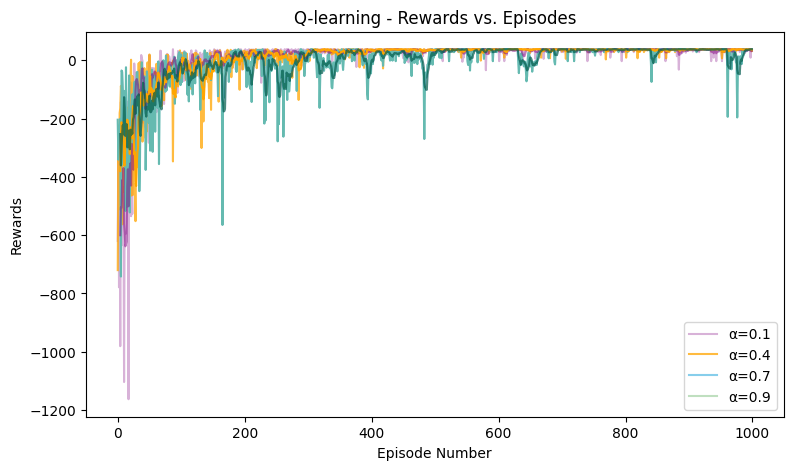

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="α=0.1", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="α=0.4", color='orange')
_ = rewards_series3.plot(ax=ax, label="α=0.7", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="α=0.9", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")


In [ ]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

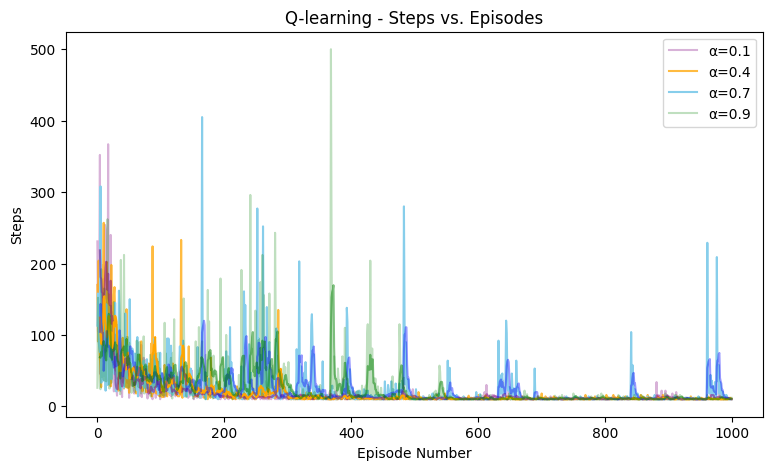

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="α=0.1", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="α=0.4", color='orange')
_ = steps_series3.plot(ax=ax, label="α=0.7", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="α=0.9", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Steps vs. Episodes")


#### Test of different Gamma values

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.4
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)


--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 0
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 0
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 0
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 0
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***eps

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.8
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 0
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 0
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 0
***ep

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 30
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 0
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 0
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***e

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.99
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 0
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 0
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 0
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 0
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***eps

In [ ]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

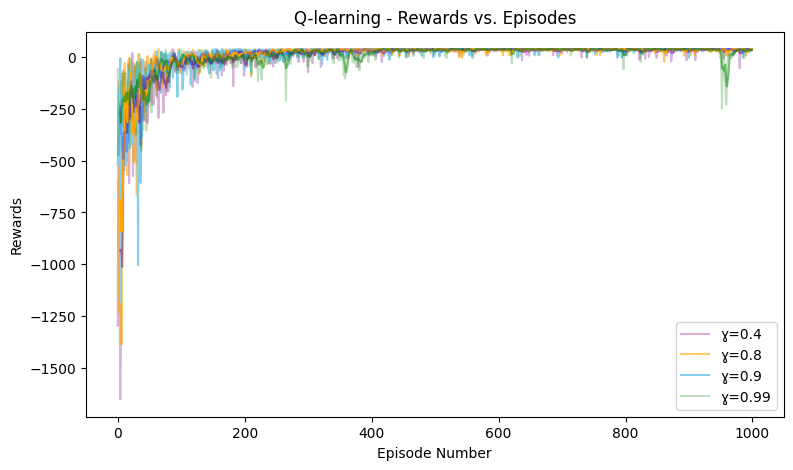

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, label="ɣ=0.4", color='purple', alpha=0.3)
_ = rewards_series2.plot(ax=ax,alpha=0.6, label="ɣ=0.8", color='orange')
_ = rewards_series3.plot(ax=ax,label="ɣ=0.9", color='skyblue')
_ = rewards_series4.plot(ax=ax, alpha =0.25, label="ɣ=0.99", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.25)
ax.plot(rewards_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [ ]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

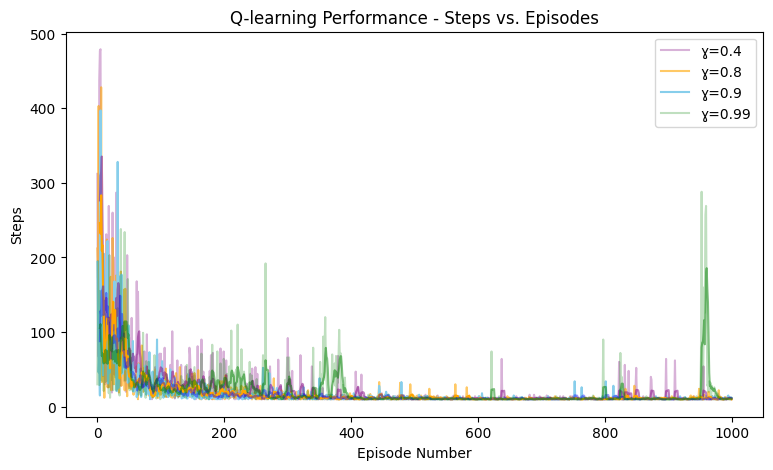

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, label="ɣ=0.4", color='purple', alpha=0.3)
_ = steps_series2.plot(ax=ax, label="ɣ=0.8", color='orange', alpha=0.6)
_ = steps_series3.plot(ax=ax, label="ɣ=0.9", color='skyblue')
_ = steps_series4.plot(ax=ax, label="ɣ=0.99", alpha=0.25, color='green')



ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different epsilon decay values

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.900
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)


--- Episode 0 ---
--reward: 0
***epsilon: 0.9
--- Episode 1 ---
--reward: 0
***epsilon: 0.81
--- Episode 2 ---
--reward: 30
***epsilon: 0.7290000000000001
--- Episode 3 ---
--reward: 30
***epsilon: 0.6561000000000001
--- Episode 4 ---
--reward: 0
***epsilon: 0.5904900000000002
--- Episode 5 ---
--reward: 30
***epsilon: 0.5314410000000002
--- Episode 6 ---
--reward: 30
***epsilon: 0.47829690000000014
--- Episode 7 ---
--reward: 30
***epsilon: 0.43046721000000016
--- Episode 8 ---
--reward: 30
***epsilon: 0.38742048900000015
--- Episode 9 ---
--reward: 30
***epsilon: 0.34867844010000015
--- Episode 10 ---
--reward: 30
***epsilon: 0.31381059609000017
--- Episode 11 ---
--reward: 30
***epsilon: 0.28242953648100017
--- Episode 12 ---
--reward: 30
***epsilon: 0.25418658283290013
--- Episode 13 ---
--reward: 30
***epsilon: 0.22876792454961012
--- Episode 14 ---
--reward: 30
***epsilon: 0.2058911320946491
--- Episode 15 ---
--reward: 30
***epsilon: 0.1853020188851842
--- Episode 16 ---
--rewar

In [ ]:
# Hyperparameters of Q-learning
alpha=0.3
gamma=0.9
epsilon = 1.0
epsilon_decay=0.990
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.99
--- Episode 1 ---
--reward: 30
***epsilon: 0.9801
--- Episode 2 ---
--reward: 30
***epsilon: 0.9702989999999999
--- Episode 3 ---
--reward: 0
***epsilon: 0.96059601
--- Episode 4 ---
--reward: 0
***epsilon: 0.9509900498999999
--- Episode 5 ---
--reward: 30
***epsilon: 0.9414801494009999
--- Episode 6 ---
--reward: 30
***epsilon: 0.9320653479069899
--- Episode 7 ---
--reward: 30
***epsilon: 0.92274469442792
--- Episode 8 ---
--reward: 30
***epsilon: 0.9135172474836407
--- Episode 9 ---
--reward: 30
***epsilon: 0.9043820750088043
--- Episode 10 ---
--reward: 30
***epsilon: 0.8953382542587163
--- Episode 11 ---
--reward: 30
***epsilon: 0.8863848717161291
--- Episode 12 ---
--reward: 30
***epsilon: 0.8775210229989678
--- Episode 13 ---
--reward: 30
***epsilon: 0.8687458127689781
--- Episode 14 ---
--reward: 30
***epsilon: 0.8600583546412883
--- Episode 15 ---
--reward: 30
***epsilon: 0.8514577710948754
--- Episode 16 ---
--reward: 30
***epsil

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.999
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 0
***epsilon: 0.999
--- Episode 1 ---
--reward: 0
***epsilon: 0.998001
--- Episode 2 ---
--reward: -10
***epsilon: 0.997002999
--- Episode 3 ---
--reward: 30
***epsilon: 0.996005996001
--- Episode 4 ---
--reward: 0
***epsilon: 0.995009990004999
--- Episode 5 ---
--reward: 30
***epsilon: 0.994014980014994
--- Episode 6 ---
--reward: 30
***epsilon: 0.993020965034979
--- Episode 7 ---
--reward: 30
***epsilon: 0.9920279440699441
--- Episode 8 ---
--reward: 30
***epsilon: 0.9910359161258742
--- Episode 9 ---
--reward: 30
***epsilon: 0.9900448802097482
--- Episode 10 ---
--reward: 30
***epsilon: 0.9890548353295385
--- Episode 11 ---
--reward: 30
***epsilon: 0.988065780494209
--- Episode 12 ---
--reward: 30
***epsilon: 0.9870777147137147
--- Episode 13 ---
--reward: 0
***epsilon: 0.986090636999001
--- Episode 14 ---
--reward: 30
***epsilon: 0.9851045463620021
--- Episode 15 ---
--reward: 30
***epsilon: 0.98411944181564
--- Episode 16 ---
--reward: 30
***epsilon: 0.

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.9999
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.9999
--- Episode 1 ---
--reward: 30
***epsilon: 0.9998000100000001
--- Episode 2 ---
--reward: 0
***epsilon: 0.9997000299990001
--- Episode 3 ---
--reward: 30
***epsilon: 0.9996000599960002
--- Episode 4 ---
--reward: 0
***epsilon: 0.9995000999900007
--- Episode 5 ---
--reward: 30
***epsilon: 0.9994001499800017
--- Episode 6 ---
--reward: 30
***epsilon: 0.9993002099650037
--- Episode 7 ---
--reward: 30
***epsilon: 0.9992002799440072
--- Episode 8 ---
--reward: 30
***epsilon: 0.9991003599160128
--- Episode 9 ---
--reward: 30
***epsilon: 0.9990004498800211
--- Episode 10 ---
--reward: 30
***epsilon: 0.9989005498350332
--- Episode 11 ---
--reward: 30
***epsilon: 0.9988006597800497
--- Episode 12 ---
--reward: 30
***epsilon: 0.9987007797140718
--- Episode 13 ---
--reward: 30
***epsilon: 0.9986009096361004
--- Episode 14 ---
--reward: 0
***epsilon: 0.9985010495451367
--- Episode 15 ---
--reward: 30
***epsilon: 0.9984011994401822
--- Episode 16 --

In [ ]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

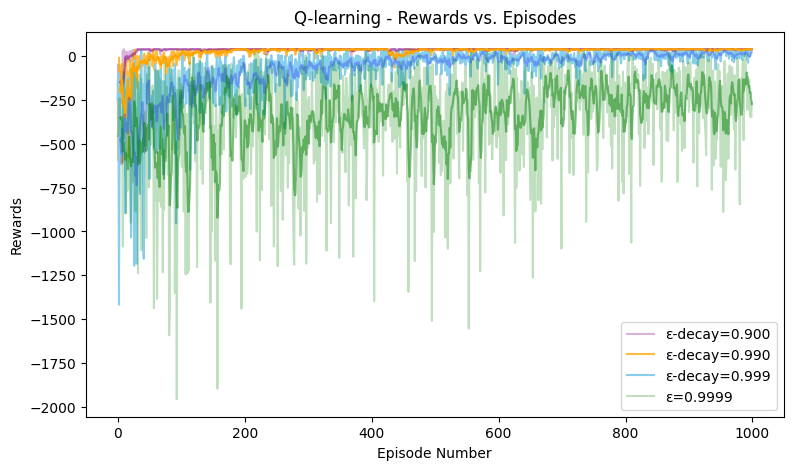

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="ε-decay=0.900",  color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="ε-decay=0.990", color='orange')
_ = rewards_series3.plot(ax=ax, label="ε-decay=0.999", color='skyblue')
_ = rewards_series4.plot(ax=ax,label="ε=0.9999", color='green', alpha=0.25)

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.25)
ax.plot(rewards_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [ ]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

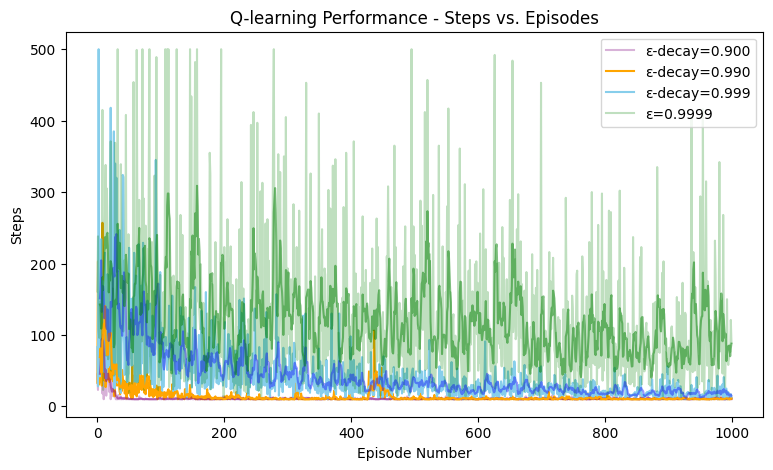

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, label="ε-decay=0.900", color='purple', alpha=0.3)
_ = steps_series2.plot(ax=ax, label="ε-decay=0.990",  color='orange')
_ = steps_series3.plot(ax=ax, label="ε-decay=0.999",  color='skyblue')
_ = steps_series4.plot(ax=ax,label="ε=0.9999", color='green', alpha =0.25)

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different epsilons values

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 0.1
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.0995
--- Episode 1 ---
--reward: 30
***epsilon: 0.09900250000000001
--- Episode 2 ---
--reward: 30
***epsilon: 0.0985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.09801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.09752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.09703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.09655206468094843
--- Episode 7 ---
--reward: 0
***epsilon: 0.09606930435754368
--- Episode 8 ---
--reward: 30
***epsilon: 0.09558895783575597
--- Episode 9 ---
--reward: 0
***epsilon: 0.09511101304657718
--- Episode 10 ---
--reward: 0
***epsilon: 0.09463545798134429
--- Episode 11 ---
--reward: 30
***epsilon: 0.09416228069143756
--- Episode 12 ---
--reward: 0
***epsilon: 0.09369146928798038
--- Episode 13 ---
--reward: 30
***epsilon: 0.09322301194154048
--- Episode 14 ---
--reward: 0
***epsilon: 0.09275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.09229311239742362
--- Episode

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 0.5
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode2 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.4975
--- Episode 1 ---
--reward: 0
***epsilon: 0.4950125
--- Episode 2 ---
--reward: 30
***epsilon: 0.4925374375
--- Episode 3 ---
--reward: 30
***epsilon: 0.49007475031250003
--- Episode 4 ---
--reward: 0
***epsilon: 0.48762437656093754
--- Episode 5 ---
--reward: 30
***epsilon: 0.48518625467813287
--- Episode 6 ---
--reward: 30
***epsilon: 0.4827603234047422
--- Episode 7 ---
--reward: 0
***epsilon: 0.4803465217877185
--- Episode 8 ---
--reward: 30
***epsilon: 0.47794478917877986
--- Episode 9 ---
--reward: 30
***epsilon: 0.47555506523288593
--- Episode 10 ---
--reward: 30
***epsilon: 0.4731772899067215
--- Episode 11 ---
--reward: 30
***epsilon: 0.47081140345718786
--- Episode 12 ---
--reward: 30
***epsilon: 0.46845734643990194
--- Episode 13 ---
--reward: 30
***epsilon: 0.46611505970770245
--- Episode 14 ---
--reward: 30
***epsilon: 0.4637844844091639
--- Episode 15 ---
--reward: 30
***epsilon: 0.4614655619871181
--- Episode 16 ---
--rew

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 0.9
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode3 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.8955
--- Episode 1 ---
--reward: 30
***epsilon: 0.8910224999999999
--- Episode 2 ---
--reward: 30
***epsilon: 0.8865673875
--- Episode 3 ---
--reward: 30
***epsilon: 0.8821345505625
--- Episode 4 ---
--reward: 30
***epsilon: 0.8777238778096875
--- Episode 5 ---
--reward: 30
***epsilon: 0.8733352584206391
--- Episode 6 ---
--reward: 30
***epsilon: 0.8689685821285359
--- Episode 7 ---
--reward: 30
***epsilon: 0.8646237392178933
--- Episode 8 ---
--reward: 30
***epsilon: 0.8603006205218038
--- Episode 9 ---
--reward: 0
***epsilon: 0.8559991174191948
--- Episode 10 ---
--reward: 30
***epsilon: 0.8517191218320987
--- Episode 11 ---
--reward: 30
***epsilon: 0.8474605262229382
--- Episode 12 ---
--reward: 30
***epsilon: 0.8432232235918236
--- Episode 13 ---
--reward: 30
***epsilon: 0.8390071074738644
--- Episode 14 ---
--reward: 30
***epsilon: 0.8348120719364951
--- Episode 15 ---
--reward: 30
***epsilon: 0.8306380115768126
--- Episode 16 ---
--rew

In [ ]:
# Hyperparameters of Q-learning
alpha=0.1
gamma=0.9
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.05
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode4 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***epsilon: 0.995
--- Episode 1 ---
--reward: 30
***epsilon: 0.990025
--- Episode 2 ---
--reward: 0
***epsilon: 0.985074875
--- Episode 3 ---
--reward: 30
***epsilon: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***epsilon: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***epsilon: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***epsilon: 0.9655206468094844
--- Episode 7 ---
--reward: -1
***epsilon: 0.960693043575437
--- Episode 8 ---
--reward: 30
***epsilon: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***epsilon: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***epsilon: 0.946354579813443
--- Episode 11 ---
--reward: 30
***epsilon: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***epsilon: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***epsilon: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***epsilon: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***epsilon: 0.9229311239742362
--- Episode 16 ---
--reward: 30
***

In [ ]:
rewards_series1=pd.Series(df_episode1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode4['Reward'].values, name="Reward")

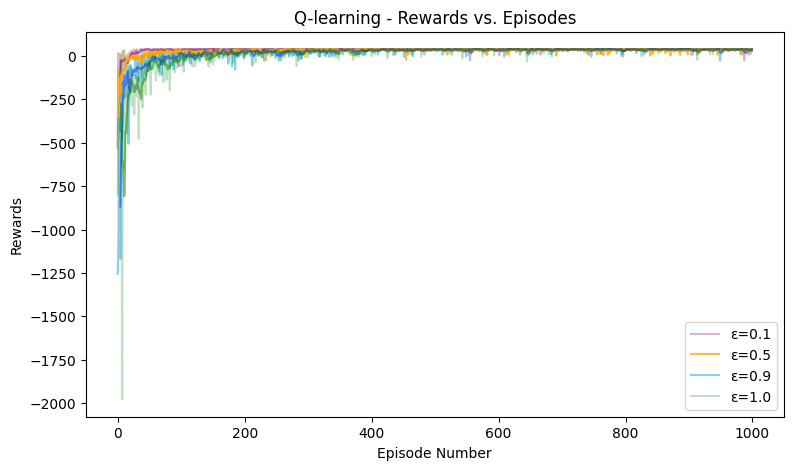

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, label="ε=0.1", color='purple', alpha=0.3)
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="ε=0.5", color='orange')
_ = rewards_series3.plot(ax=ax, label="ε=0.9", color='skyblue')
_ = rewards_series4.plot(ax=ax, alpha =0.25, label="ε=1.0", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [ ]:
steps_series1=pd.Series(df_episode1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode4['Num_steps'].values, name="Step")

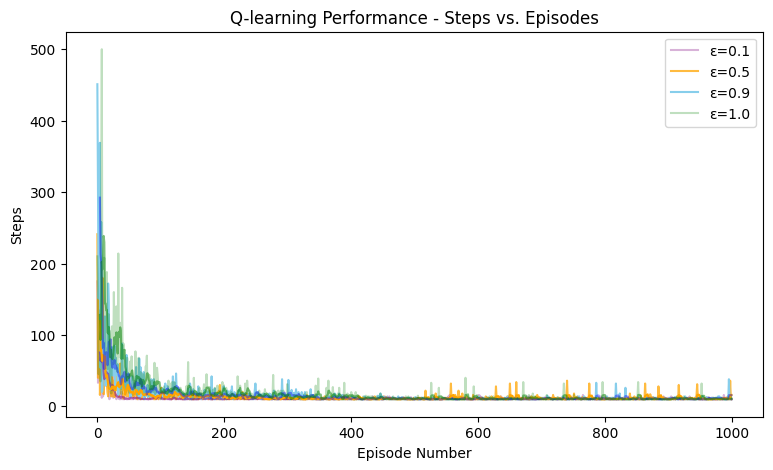

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, label="ε=0.1", color='purple', alpha=0.3)
_ = steps_series2.plot(ax=ax,alpha=0.75, label="ε=0.5", color='orange')
_ = steps_series3.plot(ax=ax, label="ε=0.9", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha =0.25, label="ε=1.0", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning Performance - Steps vs. Episodes")

## 2. Experiment with Softmax policy

#### Q-learning and softmax policy

In [ ]:
def softmax(q_table, state_index, temperature):
    q_value = q_table[state_index]
    q_value = np.array(q_value)
    max_q = np.max(q_value)
    exp_q = np.exp((q_value - max_q) / temperature)
    probability = exp_q / np.sum(exp_q)
    action = np.random.choice(len(q_value), p=probability)
    return action

In [ ]:
# Q-learning with Softmax policy

def state_to_index(state, width):
    return state[0] * width + state[1]

# Q-learning function
def q_learning(env, alpha, gamma, temperature, min_temperature, temperature_decay, episodes,max_steps):

    # Initialize Q-table with shape (36, 4) = (state, action)
    q_table = np.zeros((env.gridsize[0] * env.gridsize[1], env.action_space.n))

    # Vi
    # Create a df to store episode and number of steps
    df_epsisode = pd.DataFrame(columns=['Episode','Num_steps', 'Reward'])
    total_reward = 0

    # Sultana
    for episode in range(episodes):

        # Update temperature
        # Decay temperature to reduce exploration over time
        temperature = max(min_temperature, temperature * temperature_decay)

        state = env.reset()
        # Convert state to index
        state_index = state_to_index(state, env.gridsize[1])
        done = False

        # Vi
        num_step = 0
        reward_per_episode = 0
        print("--- Episode",episode,"---")

        while not done and num_step <max_steps:

            # Choose action based on sotfmax policy
            action = softmax(q_table, state_index, temperature)
            # Take the action and observe the result
            next_state, reward, done = env.step(action)

            # Convert next state to index
            next_state_index = state_to_index(next_state, env.gridsize[1])

            # Update Q-table based on the Q-learning formula
            q_table[state_index, action] += alpha * (reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action])

            # Move to the next state
            state = next_state
            # Update the state index
            state_index = next_state_index
            #env.render_2()

            # Add up reward
            total_reward +=reward

            # Track number of steps
            num_step = num_step+1
            # Track reward per episode

            reward_per_episode += reward

        print("--reward:", reward)
        print('***temperature:', temperature)

        new_track = {'Episode':episode, 'Num_steps':num_step, 'Reward':reward_per_episode}
        df_epsisode.loc[len(df_epsisode)] = new_track

    return q_table, total_reward, df_epsisode


#### Run Q-learning

In [ ]:
temperature = 1.0
min_temperature = 0.01
temperature_decay = 0.995
alpha=0.05
gamma=0.9
episodes=1000
total_reward = 0
max_steps=500

if __name__ == "__main__":
    env = gridEnv()
    # Start with new environment
    state = env.reset()
    # Show the environment
    q_table, total_reward, df_episode_soft = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print()
    print(episodes)
    print(q_table)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 30
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***te

In [ ]:
success=0
for i in range (len(df_episode_soft['Episode'].values)):
  if df_episode_soft['Reward'].values[i] > 29:
    success +=1

print('Successful episodes:',success)

Successful episodes: 935


In [ ]:
rewards_series=pd.Series(df_episode_soft['Reward'].values, name="Reward")
steps_series=pd.Series(df_episode_soft['Num_steps'].values, name="Step")

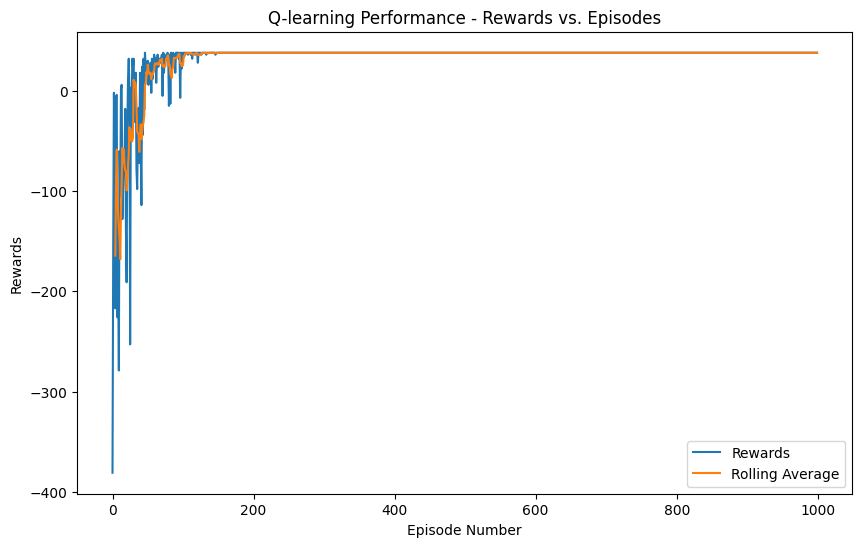

In [ ]:
#### Plot of Rewards vs. Episodes
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = rewards_series.plot(ax=axes, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Rewards")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Rewards vs. Episodes")

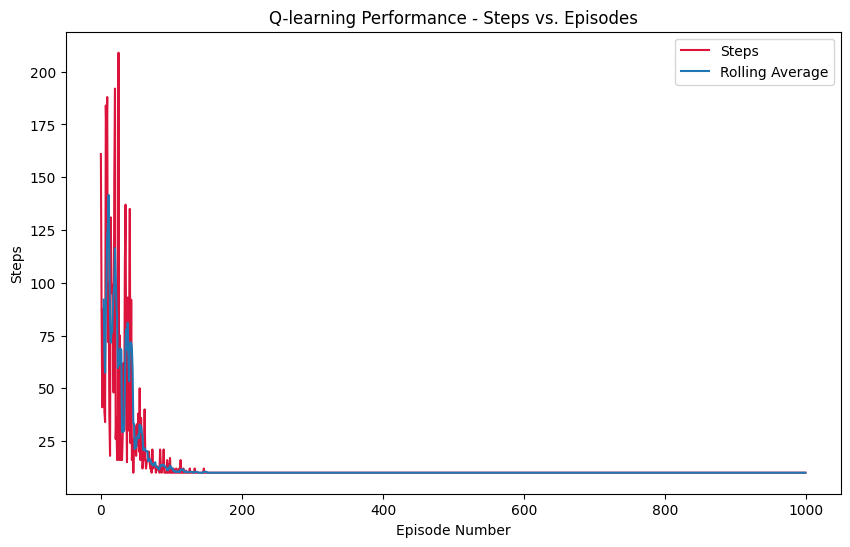

In [ ]:
#### Plot of Steps vs. Episodes
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = steps_series.plot(ax=axes, label="Steps", color='crimson')
_ = (steps_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Steps")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Steps vs. Episodes")

#### Random Search: Best parameter

In [ ]:
import random
min_temperature=0.001
max_steps=500

def random_search_q_learning(env, param_grid, num_samples=80):
    best_params = None
    best_performance = float('-inf')

    for _ in range(num_samples):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        temperature = random.choice(param_grid['temperature'])
        temperature_decay = random.choice(param_grid['temperature_decay'])
        episodes = random.choice(param_grid['episodes'])

        total_reward = 0

        q_table, total_reward, df_episode = q_learning(env, alpha, gamma, temperature, min_temperature, temperature_decay, episodes, max_steps)

        average_rewards = np.mean(df_episode['Reward'].values[-500:])

        if average_rewards > best_performance:
            best_performance = average_rewards
            best_params = {'alpha': alpha, 'gamma': gamma, 'temperature': temperature, 'temperature_decay': temperature_decay, 'episodes': episodes}

    return best_params, best_performance

# Define the hyperparameter grid (ranges for each hyperparameter)
param_grid = {
    'alpha': [0.1, 0.4, 0.7, 0.9],  # Learning rate
    'gamma': [0.4, 0.8, 0.9, 0.99],  # Discount factor
    'temperature': [0.1, 0.5, 1.0, 4.0],  # Initial temperature
    'temperature_decay': [0.5, 0.8, 0.9, 0.99],  # Decay factor for temperature
    'episodes': [500, 1000, 1500],  # Number of episodes to run
}


# Perform random search
best_params, best_performance = random_search_q_learning(env, param_grid, num_samples=80)

# Output the results
print(f"Best parameters: {best_params}")
print(f"Best performance: {best_performance}")

Streaming output truncated to the last 5000 lines.
--- Episode 334 ---
--reward: 30
***temperature: 0.1379908155806559
--- Episode 335 ---
--reward: 30
***temperature: 0.13661090742484935
--- Episode 336 ---
--reward: 30
***temperature: 0.13524479835060085
--- Episode 337 ---
--reward: 30
***temperature: 0.13389235036709485
--- Episode 338 ---
--reward: 30
***temperature: 0.1325534268634239
--- Episode 339 ---
--reward: 30
***temperature: 0.13122789259478965
--- Episode 340 ---
--reward: 30
***temperature: 0.12991561366884175
--- Episode 341 ---
--reward: 30
***temperature: 0.12861645753215334
--- Episode 342 ---
--reward: 30
***temperature: 0.1273302929568318
--- Episode 343 ---
--reward: 30
***temperature: 0.12605699002726348
--- Episode 344 ---
--reward: 30
***temperature: 0.12479642012699084
--- Episode 345 ---
--reward: 30
***temperature: 0.12354845592572093
--- Episode 346 ---
--reward: 30
***temperature: 0.12231297136646373
--- Episode 347 ---
--reward: 30
***temperature: 0.1210

In [ ]:
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.1
gamma=0.9
episodes=1500
total_reward = 0
max_steps=300

if __name__ == "__main__":
    env = gridEnv()
    # Start with new environment
    state = env.reset()
    # Show the environment
    q_table, total_reward, df_episode_soft = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print()
    print(episodes)
    print(q_table)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 0
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 30
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***tem

In [ ]:
rewards_series=pd.Series(df_episode_soft['Reward'].values, name="Reward")
steps_series=pd.Series(df_episode_soft['Num_steps'].values, name="Step")

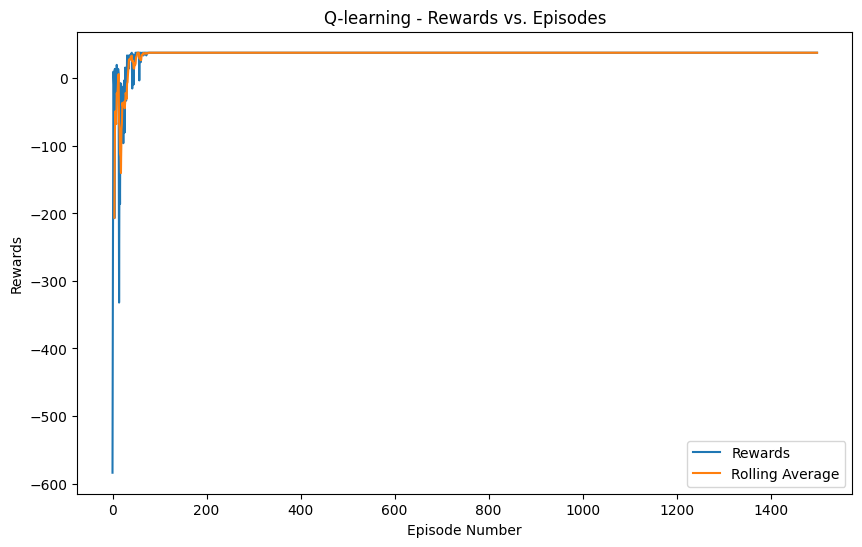

In [ ]:
#### Plot of Rewards and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = rewards_series.plot(ax=axes, label="Rewards")
_ = (rewards_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Rewards")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning - Rewards vs. Episodes")

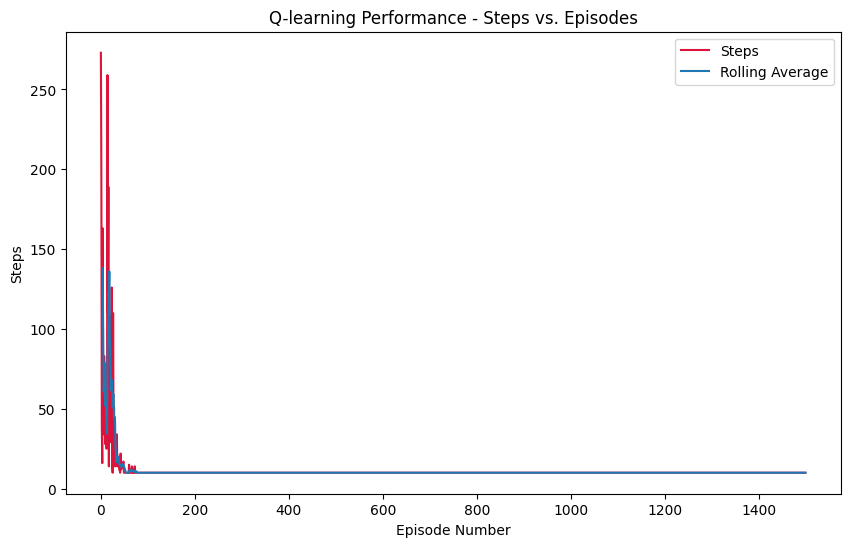

In [ ]:
#### Plot of Steps and rolling average per episode
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
_ = steps_series.plot(ax=axes, label="Steps", color='crimson')
_ = (steps_series.rolling(window=5).mean().rename("Rolling Average").plot(ax=axes))
_ = axes.legend()
_ = axes.set_ylabel("Steps")
_ = axes.set_xlabel("Episode Number")
_ = axes.set_title("Q-learning Performance - Steps vs. Episodes")

#### Test of different Alpha values

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 0
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 0
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 0
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 0
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***temper

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.1
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 0
***temperature: 0.990025
--- Episode 2 ---
--reward: 0
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 0
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 30
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 0
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***temper

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.5
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 0
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 0
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 0
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***tempe

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.8
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 0
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 0
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 30
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 0
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 0
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***temper

In [ ]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

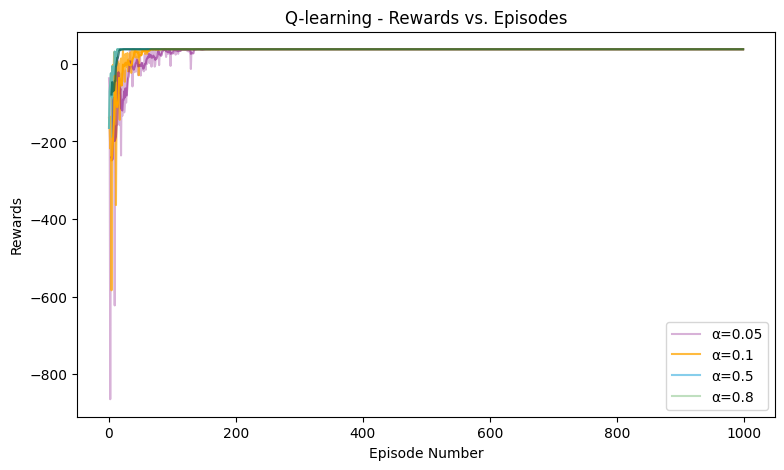

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="α=0.05", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="α=0.1", color='orange')
_ = rewards_series3.plot(ax=ax, label="α=0.5", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="α=0.8", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [ ]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

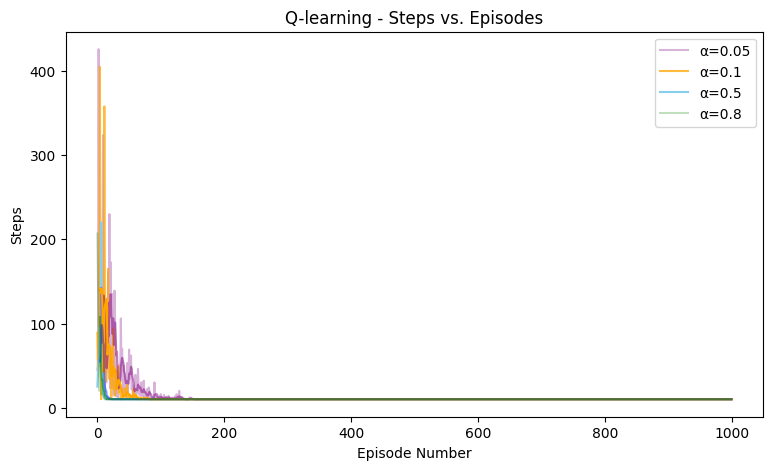

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="α=0.05", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="α=0.1", color='orange')
_ = steps_series3.plot(ax=ax, label="α=0.5", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="α=0.8", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Steps vs. Episodes")

#### Test of different Gamma values

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.4
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 30
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 0
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 0
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***temp

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 0
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 30
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 0
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***temp

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.9
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 30
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 0
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***tem

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.99
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 0
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 30
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 0
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 0
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 30
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 30
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***tempe

In [ ]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

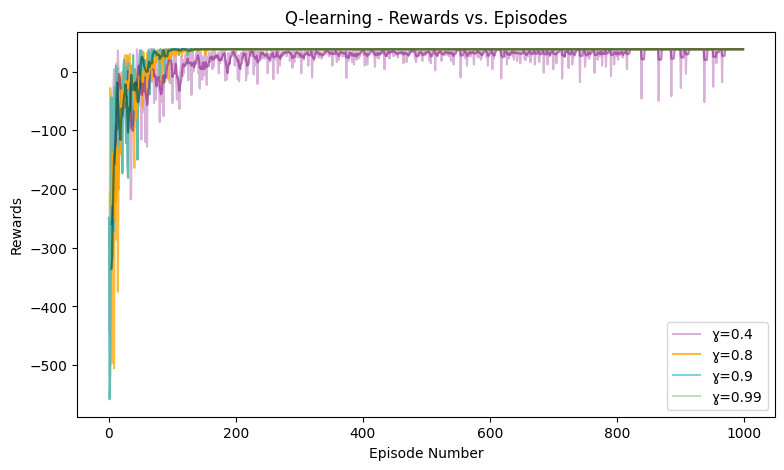

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="ɣ=0.4", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="ɣ=0.8", color='orange')
_ = rewards_series3.plot(ax=ax, label="ɣ=0.9", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="ɣ=0.99", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [ ]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

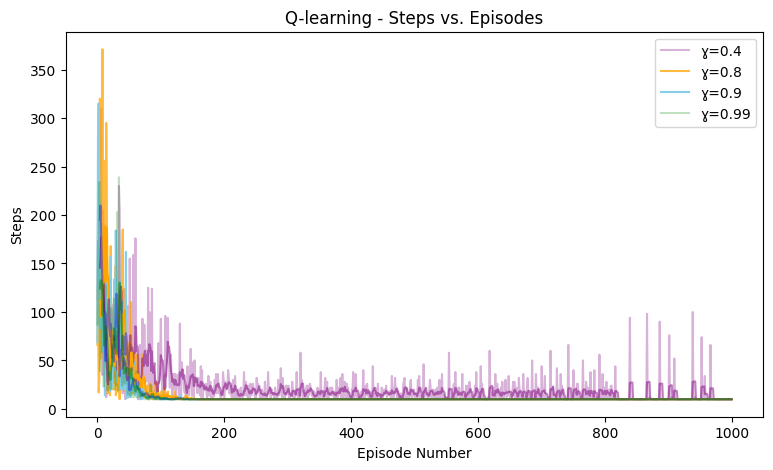

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="ɣ=0.4", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="ɣ=0.8", color='orange')
_ = steps_series3.plot(ax=ax, label="ɣ=0.9", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="ɣ=0.99", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Steps vs. Episodes")

#### Test of different temperature-decay rate

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.5
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.5
--- Episode 1 ---
--reward: 0
***temperature: 0.25
--- Episode 2 ---
--reward: 0
***temperature: 0.125
--- Episode 3 ---
--reward: 0
***temperature: 0.0625
--- Episode 4 ---
--reward: 30
***temperature: 0.03125
--- Episode 5 ---
--reward: 30
***temperature: 0.015625
--- Episode 6 ---
--reward: 30
***temperature: 0.0078125
--- Episode 7 ---
--reward: 0
***temperature: 0.00390625
--- Episode 8 ---
--reward: 30
***temperature: 0.001953125
--- Episode 9 ---
--reward: 30
***temperature: 0.001
--- Episode 10 ---
--reward: 30
***temperature: 0.001
--- Episode 11 ---
--reward: 30
***temperature: 0.001
--- Episode 12 ---
--reward: 30
***temperature: 0.001
--- Episode 13 ---
--reward: 30
***temperature: 0.001
--- Episode 14 ---
--reward: 30
***temperature: 0.001
--- Episode 15 ---
--reward: 30
***temperature: 0.001
--- Episode 16 ---
--reward: 30
***temperature: 0.001
--- Episode 17 ---
--reward: 0
***temperature: 0.001
--- Episode 18 ---
--rewa

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.8
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.8
--- Episode 1 ---
--reward: 30
***temperature: 0.6400000000000001
--- Episode 2 ---
--reward: 30
***temperature: 0.5120000000000001
--- Episode 3 ---
--reward: 30
***temperature: 0.40960000000000013
--- Episode 4 ---
--reward: 0
***temperature: 0.32768000000000014
--- Episode 5 ---
--reward: 30
***temperature: 0.2621440000000001
--- Episode 6 ---
--reward: 30
***temperature: 0.2097152000000001
--- Episode 7 ---
--reward: 30
***temperature: 0.1677721600000001
--- Episode 8 ---
--reward: 30
***temperature: 0.13421772800000006
--- Episode 9 ---
--reward: 30
***temperature: 0.10737418240000006
--- Episode 10 ---
--reward: 30
***temperature: 0.08589934592000005
--- Episode 11 ---
--reward: 30
***temperature: 0.06871947673600004
--- Episode 12 ---
--reward: 0
***temperature: 0.054975581388800036
--- Episode 13 ---
--reward: 30
***temperature: 0.043980465111040035
--- Episode 14 ---
--reward: 0
***temperature: 0.03518437208883203
--- Episode 

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.990
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.99
--- Episode 1 ---
--reward: 30
***temperature: 0.9801
--- Episode 2 ---
--reward: 30
***temperature: 0.9702989999999999
--- Episode 3 ---
--reward: 30
***temperature: 0.96059601
--- Episode 4 ---
--reward: 30
***temperature: 0.9509900498999999
--- Episode 5 ---
--reward: 30
***temperature: 0.9414801494009999
--- Episode 6 ---
--reward: 0
***temperature: 0.9320653479069899
--- Episode 7 ---
--reward: 30
***temperature: 0.92274469442792
--- Episode 8 ---
--reward: 30
***temperature: 0.9135172474836407
--- Episode 9 ---
--reward: 30
***temperature: 0.9043820750088043
--- Episode 10 ---
--reward: 30
***temperature: 0.8953382542587163
--- Episode 11 ---
--reward: 30
***temperature: 0.8863848717161291
--- Episode 12 ---
--reward: 30
***temperature: 0.8775210229989678
--- Episode 13 ---
--reward: 30
***temperature: 0.8687458127689781
--- Episode 14 ---
--reward: 0
***temperature: 0.8600583546412883
--- Episode 15 ---
--reward: 30
***temperat

In [ ]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.01
temperature_decay = 0.999
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 0
***temperature: 0.0999
--- Episode 1 ---
--reward: 30
***temperature: 0.0998001
--- Episode 2 ---
--reward: 30
***temperature: 0.0997002999
--- Episode 3 ---
--reward: 30
***temperature: 0.0996005996001
--- Episode 4 ---
--reward: 30
***temperature: 0.0995009990004999
--- Episode 5 ---
--reward: 30
***temperature: 0.0994014980014994
--- Episode 6 ---
--reward: 30
***temperature: 0.0993020965034979
--- Episode 7 ---
--reward: 30
***temperature: 0.09920279440699441
--- Episode 8 ---
--reward: 30
***temperature: 0.09910359161258742
--- Episode 9 ---
--reward: 30
***temperature: 0.09900448802097483
--- Episode 10 ---
--reward: 30
***temperature: 0.09890548353295386
--- Episode 11 ---
--reward: 0
***temperature: 0.0988065780494209
--- Episode 12 ---
--reward: 30
***temperature: 0.09870777147137148
--- Episode 13 ---
--reward: 0
***temperature: 0.0986090636999001
--- Episode 14 ---
--reward: 30
***temperature: 0.0985104546362002
--- Episode 15 ---
--reward: 30
*

In [ ]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

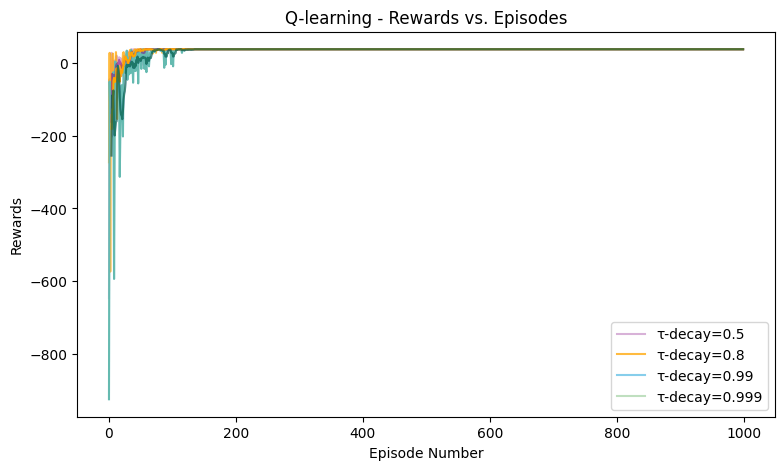

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="τ-decay=0.5", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="τ-decay=0.8", color='orange')
_ = rewards_series3.plot(ax=ax, label="τ-decay=0.99", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="τ-decay=0.999", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [ ]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

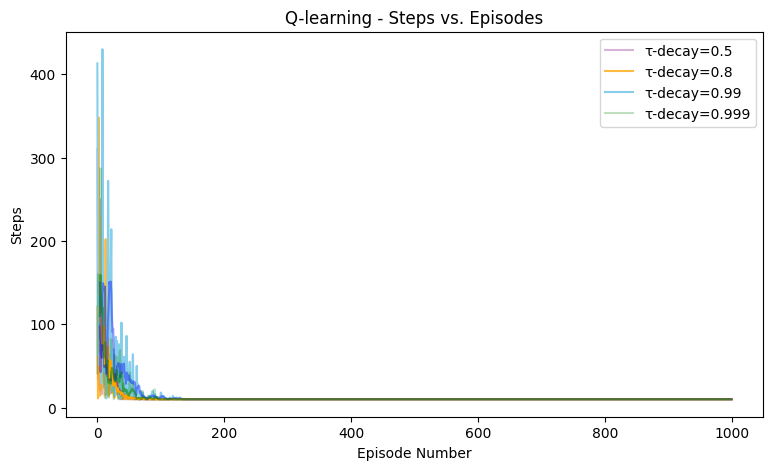

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="τ-decay=0.5", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="τ-decay=0.8", color='orange')
_ = steps_series3.plot(ax=ax, label="τ-decay=0.99", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="τ-decay=0.999", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Steps vs. Episodes")

#### Test of different temperature values

In [ ]:
# Hyperparameters of Q-learning
temperature = 0.1
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft1 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.0995
--- Episode 1 ---
--reward: 30
***temperature: 0.09900250000000001
--- Episode 2 ---
--reward: 30
***temperature: 0.0985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.09801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.09752487531218751
--- Episode 5 ---
--reward: 30
***temperature: 0.09703725093562657
--- Episode 6 ---
--reward: 30
***temperature: 0.09655206468094843
--- Episode 7 ---
--reward: 30
***temperature: 0.09606930435754368
--- Episode 8 ---
--reward: 30
***temperature: 0.09558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.09511101304657718
--- Episode 10 ---
--reward: 30
***temperature: 0.09463545798134429
--- Episode 11 ---
--reward: 30
***temperature: 0.09416228069143756
--- Episode 12 ---
--reward: 0
***temperature: 0.09369146928798038
--- Episode 13 ---
--reward: 0
***temperature: 0.09322301194154048
--- Episode 14 ---
--reward: 30
***temperature: 0.09275689688183278
--- Episode 

In [ ]:
# Hyperparameters of Q-learning
temperature = 0.5
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft2 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.4975
--- Episode 1 ---
--reward: 0
***temperature: 0.4950125
--- Episode 2 ---
--reward: 30
***temperature: 0.4925374375
--- Episode 3 ---
--reward: 0
***temperature: 0.49007475031250003
--- Episode 4 ---
--reward: 30
***temperature: 0.48762437656093754
--- Episode 5 ---
--reward: 30
***temperature: 0.48518625467813287
--- Episode 6 ---
--reward: 30
***temperature: 0.4827603234047422
--- Episode 7 ---
--reward: 30
***temperature: 0.4803465217877185
--- Episode 8 ---
--reward: 30
***temperature: 0.47794478917877986
--- Episode 9 ---
--reward: 0
***temperature: 0.47555506523288593
--- Episode 10 ---
--reward: 30
***temperature: 0.4731772899067215
--- Episode 11 ---
--reward: 30
***temperature: 0.47081140345718786
--- Episode 12 ---
--reward: 30
***temperature: 0.46845734643990194
--- Episode 13 ---
--reward: 30
***temperature: 0.46611505970770245
--- Episode 14 ---
--reward: 30
***temperature: 0.4637844844091639
--- Episode 15 ---
--reward

In [ ]:
# Hyperparameters of Q-learning
temperature = 1.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft3 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 0.995
--- Episode 1 ---
--reward: 30
***temperature: 0.990025
--- Episode 2 ---
--reward: 30
***temperature: 0.985074875
--- Episode 3 ---
--reward: 30
***temperature: 0.9801495006250001
--- Episode 4 ---
--reward: 30
***temperature: 0.9752487531218751
--- Episode 5 ---
--reward: 0
***temperature: 0.9703725093562657
--- Episode 6 ---
--reward: 0
***temperature: 0.9655206468094844
--- Episode 7 ---
--reward: 0
***temperature: 0.960693043575437
--- Episode 8 ---
--reward: 0
***temperature: 0.9558895783575597
--- Episode 9 ---
--reward: 30
***temperature: 0.9511101304657719
--- Episode 10 ---
--reward: 30
***temperature: 0.946354579813443
--- Episode 11 ---
--reward: 30
***temperature: 0.9416228069143757
--- Episode 12 ---
--reward: 0
***temperature: 0.9369146928798039
--- Episode 13 ---
--reward: 30
***temperature: 0.9322301194154049
--- Episode 14 ---
--reward: 0
***temperature: 0.9275689688183278
--- Episode 15 ---
--reward: 30
***temperat

In [ ]:
# Hyperparameters of Q-learning
temperature = 4.0
min_temperature = 0.001
temperature_decay = 0.995
alpha=0.05
gamma=0.8
episodes=1000
max_steps=500

total_reward = 0

if __name__ == "__main__":
    # Call Mario-grid environment
    env = gridEnv()
    # Start with new environment
    state = env.reset(seed=42)
    # Vi
    q_table, total_reward, df_episode_soft4 = q_learning(env,alpha, gamma, temperature, min_temperature, temperature_decay , episodes, max_steps)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)

--- Episode 0 ---
--reward: 30
***temperature: 3.98
--- Episode 1 ---
--reward: 30
***temperature: 3.9601
--- Episode 2 ---
--reward: 30
***temperature: 3.9402995
--- Episode 3 ---
--reward: 30
***temperature: 3.9205980025000002
--- Episode 4 ---
--reward: 30
***temperature: 3.9009950124875004
--- Episode 5 ---
--reward: 30
***temperature: 3.881490037425063
--- Episode 6 ---
--reward: 30
***temperature: 3.8620825872379374
--- Episode 7 ---
--reward: 30
***temperature: 3.842772174301748
--- Episode 8 ---
--reward: 0
***temperature: 3.823558313430239
--- Episode 9 ---
--reward: 30
***temperature: 3.8044405218630875
--- Episode 10 ---
--reward: 30
***temperature: 3.785418319253772
--- Episode 11 ---
--reward: 30
***temperature: 3.766491227657503
--- Episode 12 ---
--reward: 30
***temperature: 3.7476587715192156
--- Episode 13 ---
--reward: 30
***temperature: 3.7289204776616196
--- Episode 14 ---
--reward: 30
***temperature: 3.7102758752733114
--- Episode 15 ---
--reward: 30
***temperature

In [ ]:
rewards_series1=pd.Series(df_episode_soft1['Reward'].values, name="Reward")
rewards_series2=pd.Series(df_episode_soft2['Reward'].values, name="Reward")
rewards_series3=pd.Series(df_episode_soft3['Reward'].values, name="Reward")
rewards_series4=pd.Series(df_episode_soft4['Reward'].values, name="Reward")

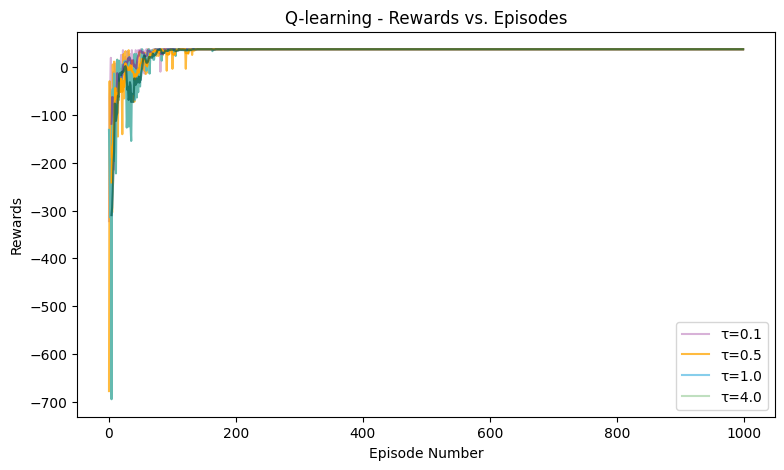

In [ ]:
######## Plot of Rewards and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = rewards_series1.plot(ax=ax, alpha=0.3, label="τ=0.1", color='purple')
_ = rewards_series2.plot(ax=ax,alpha=0.75, label="τ=0.5", color='orange')
_ = rewards_series3.plot(ax=ax, label="τ=1.0", color='skyblue')
_ = rewards_series3.plot(ax=ax, alpha=0.25, label="τ=4.0", color='green')

ax.plot(rewards_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(rewards_series2.rolling(window=5).mean(), color='orange')
ax.plot(rewards_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(rewards_series3.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Rewards")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Rewards vs. Episodes")

In [ ]:
steps_series1=pd.Series(df_episode_soft1['Num_steps'].values, name="Step")
steps_series2=pd.Series(df_episode_soft2['Num_steps'].values, name="Step")
steps_series3=pd.Series(df_episode_soft3['Num_steps'].values, name="Step")
steps_series4=pd.Series(df_episode_soft4['Num_steps'].values, name="Step")

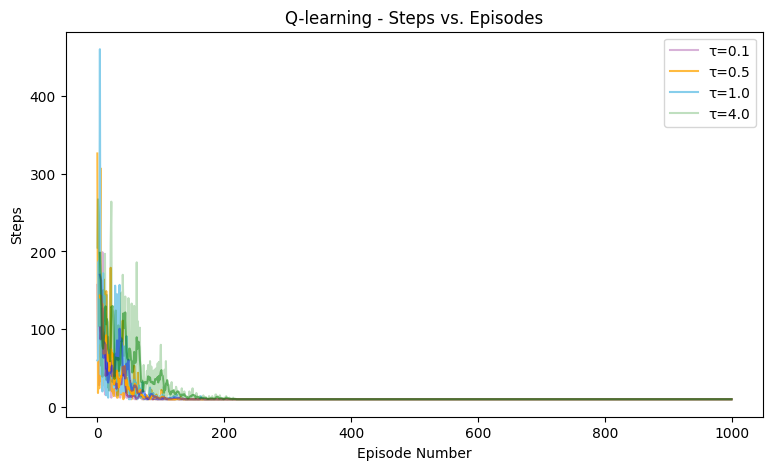

In [ ]:
######## Plot of Steps and rolling average per episode ########
fig, ax = plt.subplots(1, 1, figsize=(9, 5), sharex=True, sharey=True)
_ = steps_series1.plot(ax=ax, alpha=0.3, label="τ=0.1", color='purple')
_ = steps_series2.plot(ax=ax,alpha=0.75, label="τ=0.5", color='orange')
_ = steps_series3.plot(ax=ax, label="τ=1.0", color='skyblue')
_ = steps_series4.plot(ax=ax, alpha=0.25, label="τ=4.0", color='green')

ax.plot(steps_series1.rolling(window=5).mean(), color='purple', alpha=0.5)
ax.plot(steps_series2.rolling(window=5).mean(), color='orange')
ax.plot(steps_series3.rolling(window=5).mean(), color='blue', alpha=0.4)
ax.plot(steps_series4.rolling(window=5).mean(), color='green', alpha=0.5)

_ = ax.legend()
_ = ax.set_ylabel("Steps")
_ = ax.set_xlabel("Episode Number")
_ = ax.set_title("Q-learning - Steps vs. Episodes")

## Optuna test

In [ ]:
#pip install optuna
# import optuna
# from optuna.trial import TrialState

# # Optuna objective function
# def objective(trial):
#   # Hyperparameters to tune
#   alpha = trial.suggest_int('alpha', 0.01, 0.9)
#   gamma = trial.suggest_int('gamma', 0.8, 0.99)
#   epsilon = trial.suggest_int('epsilon', 0.4, 1.0)
#   epsilon_decay = trial.suggest_int('epsilon_decay', 0.8, 0.9999)

#   # Initialize total reward tracker
#   total_reward = 0

#   # Call Q-learning function with the current set of hyperparameters
#   q_table, total_reward, df_episode = q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, max_steps)
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30, n_jobs=-1)
# q_trials = study.trials_dataframe()
# q_trials.head()
# print("Best Hyperparameters:", study.best_params)